# Pytorch Rals-C-SAGAN
* Ra - Relativistic Average;
* Ls - Least Squares;
* C - Conditional;
* SA - Self-Attention;
* DCGAN - Deep Convolutional Generative Adversarial Network

<br>
References:
* https://www.kaggle.com/speedwagon/ralsgan-dogs
* https://www.kaggle.com/cdeotte/dog-breed-cgan
* https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py
* https://github.com/voletiv/self-attention-GAN-pytorch/blob/master/sagan_models.py

In [1]:
# loss_calculation = 'hinge'
loss_calculation = 'rals'
batch_size = 32
crop_dog = True #犬のアノテーションを使用するかどうか
noisy_label = True #ラベルスムージング的な
R_uni = (0.75, 0.95) #ラベルスムージングするときのrealの範囲
F_uni = (0.05, 0.15) #ラベルスムージングするときのfakeの範囲
Gcbn = False # generatorにConditionalBatchNorm2dを使うかどうか
Glrelu = False # generatorにLeakyLeLUを使うかどうか
flip_p = 0.5 # RandomHorizontalFlipの割合
n_epochs = 301

use_pixelnorm = False
test_mode = True # commit時はFalseにしてinternetをoffにする
colapse_thre = 0.5 # modecolapseのしきい値

use_Gattn = False
use_Dattn = False

# optimizerゾーン
# G_opt = 'adaboundw'
G_opt = 'adam'
G_lr = 0.002
G_betas = (0.5, 0.999) #ada系のみ
G_final_lr=0.5 # adaboundのみ
G_weight_decay=5e-4 # adaboundのみ
G_eta_min = 0.0003 # コサインアニーリングのパラメタ

# D_opt = 'adaboundw'
D_opt = 'adam'
# D_opt = 'SGD'
D_lr = 0.0004
D_betas = (0.5, 0.999) #ada系のみ
D_final_lr=0.1 # adaboundのみ
D_weight_decay=0 #adaboundのみ
D_eta_min = 0.00003

In [2]:
import requests
import datetime
import io
import os

import matplotlib.pyplot as plt

def notify(messages, files=None):
    url = "https://notify-api.line.me/api/notify"
    token = 'bVQ1eoiM1a8NuLwpw6iRRwnvPruRjRpjWMilh0D8E36'
    headers = {"Authorization" : "Bearer "+ token}
    payload = {"message" :  messages}

    r = requests.post(url ,headers = headers ,params=payload,files=files)

In [3]:
import os
import PIL
import torchvision
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import xml.etree.ElementTree as ET
import numpy as np

import imgaug as ia
import imgaug.augmenters as iaa

import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.nn.init import xavier_uniform_


import time
import torch
import torch.nn as nn

import torch.nn.parallel
import torch.optim as optim
from torch.nn.utils import spectral_norm
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg

import torch.nn.functional as F
from torch.nn import Parameter


import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image
import zipfile

from tqdm import tqdm_notebook as tqdm
torch.backends.cudnn.deterministic = True

kernel_start_time = time.perf_counter()

# Helper Blocks

In [4]:
import math
import torch
from torch.optim import Optimizer


class AdaBound(Optimizer):
    """Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss

class AdaBoundW(Optimizer):
    """Implements AdaBound algorithm with Decoupled Weight Decay (arxiv.org/abs/1711.05101)
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBoundW, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBoundW, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                if group['weight_decay'] != 0:
                    decayed_weights = torch.mul(p.data, group['weight_decay'])
                    p.data.add_(-step_size)
                    p.data.sub_(decayed_weights)
                else:
                    p.data.add_(-step_size)

        return loss

In [5]:
# スペクトラルノルム使ったコンボそう
def snconv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
    return spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias))
# スペクトラルノルム使った全結合層
def snlinear(in_features, out_features):
    return spectral_norm(nn.Linear(in_features=in_features, out_features=out_features))

#スペクトラルノルム使ったエンべ層
def sn_embedding(num_embeddings, embedding_dim):
    return spectral_norm(nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim))

#カーネルのアテンションクラス
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_channels):
        super(Self_Attn, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_phi = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_g = snconv2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_attn = snconv2d(in_channels=in_channels//2, out_channels=in_channels, kernel_size=1, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=0)
        self.softmax  = nn.Softmax(dim=-1)
        self.sigma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        _, ch, h, w = x.size()
        # Theta path
        theta = self.snconv1x1_theta(x)
        theta = theta.view(-1, ch//8, h*w)
        # Phi path
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi)
        phi = phi.view(-1, ch//8, h*w//4)
        # Attn map
        attn = torch.bmm(theta.permute(0, 2, 1), phi)
        attn = self.softmax(attn)
        # g path
        g = self.snconv1x1_g(x)
        g = self.maxpool(g)
        g = g.view(-1, ch//2, h*w//4)
        # Attn_g
        attn_g = torch.bmm(g, attn.permute(0, 2, 1))
        attn_g = attn_g.view(-1, ch//2, h, w)
        attn_g = self.snconv1x1_attn(attn_g)
        # Out
        out = x + self.sigma * attn_g
        return out

    
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight.data[:, :num_features].fill_(1.)  # Initialize scale to 1
        self.embed.weight.data[:, num_features:].zero_()    # Initialize bias at 0

    def forward(self, inputs):
        x, y = inputs
        
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, 1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out
    

# Generator and Discriminator

In [6]:
class UpConvBlock(nn.Module):
    """
    n_cl クラス数(120),
    k_s=カーネルサイズ(4), 
    stride=stride(2), 
    padding=padding(0), 
    bias=バイアス入れるかどうか（False),
    dropout_p=dropout_p(0.0), 
    use_cbn=Conditional Batch Normalization使うかどうか(True)
    Lrelu=LeakyReLU使うかどうか(True)(FalseはReLU)
    slope=Lreluのslope(0.05)
    """
    def __init__(self, n_input, n_output, n_cl, k_s=4, stride=2, padding=0, 
                 bias=False, dropout_p=0.0, use_cbn=True, Lrelu=True, slope=0.05):
        super(UpConvBlock, self).__init__()
        self.use_cbn = use_cbn
        self.dropout_p=dropout_p
        self.upconv = spectral_norm(nn.ConvTranspose2d(n_input, n_output, kernel_size=k_s, stride=stride, padding=padding, bias=bias))
        if use_cbn:
            self.cond_bn = ConditionalBatchNorm2d(n_output, n_cl)
        else: 
            self.bn = nn.BatchNorm2d(n_output)
        if Lrelu:
            self.activ = nn.LeakyReLU(slope, inplace=True)
        else:
            self.activ = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=dropout_p)
        
    def forward(self, inputs):
        x0, labels = inputs
        
        x = self.upconv(x0)
        if self.use_cbn: 
            x = self.activ(self.cond_bn((x, labels)))
        else:            
            x = self.activ(self.bn(x))
        if self.dropout_p > 0.0: 
            x = self.dropout(x)
        return x


class Generator(nn.Module):
    def __init__(self, nz=128, num_classes=120, channels=3, nfilt=64,use_cbn=True, Lrelu=True):
        super(Generator, self).__init__()
        self.nz = nz
        self.num_classes = num_classes
        self.channels = channels
        
        self.label_emb = nn.Embedding(num_classes, nz)
        self.upconv1 = UpConvBlock(2*nz, nfilt*8, num_classes, k_s=4, stride=1, padding=0, use_cbn=use_cbn,Lrelu=Lrelu) #4*4
        self.upconv2 = UpConvBlock(nfilt*8, nfilt*4, num_classes, k_s=4, stride=2, padding=1,use_cbn=use_cbn,Lrelu=Lrelu) #8*8 
        self.upconv3 = UpConvBlock(nfilt*4, nfilt*2, num_classes, k_s=4, stride=2, padding=1,use_cbn=use_cbn,Lrelu=Lrelu) # 16*16
        self.upconv4 = UpConvBlock(nfilt*2, nfilt, num_classes, k_s=4, stride=2, padding=1, use_cbn=use_cbn,Lrelu=Lrelu) #32*32
        self.upconv5 = UpConvBlock(nfilt, 3, num_classes, k_s=4, stride=2, padding=1, use_cbn=use_cbn,Lrelu=Lrelu) #
        if use_Gattn:
            self.self_attn = Self_Attn(nfilt)
        self.out_conv = spectral_norm(nn.Conv2d(3, 3, 3, 1, 1, bias=False))
        self.out_activ = nn.Tanh()
        
    def forward(self, inputs):
        z, labels = inputs
        
        enc = self.label_emb(labels).view((-1, self.nz, 1, 1))
        enc = F.normalize(enc, p=2, dim=1)
        x = torch.cat((z, enc), 1)
        
        x = self.upconv1((x, labels))
        x = self.upconv2((x, labels))
        x = self.upconv3((x, labels))
        x = self.upconv4((x, labels))
        if use_Gattn:
            x = self.self_attn(x)        
        x = self.upconv5((x, labels))
        x = self.out_conv(x)
        img = self.out_activ(x)              
        return img
    
    
class Discriminator(nn.Module):
    def __init__(self, num_classes=120, channels=3, nfilt=64):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.num_classes = num_classes

        def down_convlayer(n_input, n_output, k_s=4, stride=2, padding=0, dropout_p=0.0):
            block = [spectral_norm(nn.Conv2d(n_input, n_output, kernel_size=k_s, stride=stride, padding=padding, bias=False)),
                     nn.BatchNorm2d(n_output),
                     nn.LeakyReLU(0.2, inplace=True),
                    ]
            if dropout_p > 0.0: block.append(nn.Dropout(p=dropout_p))
            return block
        
        self.label_emb = nn.Embedding(num_classes, 64*64)
        if use_Dattn:
            self.model = nn.Sequential(
                *down_convlayer(self.channels + 1, nfilt, 4, 2, 1), 
                Self_Attn(nfilt),                            
                *down_convlayer(nfilt, nfilt*2, 4, 2, 1,dropout_p=0.2),
                *down_convlayer(nfilt*2, nfilt*4, 4, 2, 1,dropout_p=0.5),
                *down_convlayer(nfilt*4, nfilt*8, 4, 2, 1,dropout_p=0.2),
                spectral_norm(nn.Conv2d(nfilt*8, 1, 4, 1, 0, bias=False)),
            )

        else:
            self.model = nn.Sequential(
                *down_convlayer(self.channels + 1, nfilt, 4, 2, 1),            
                *down_convlayer(nfilt, nfilt*2, 4, 2, 1,dropout_p=0.2),
                *down_convlayer(nfilt*2, nfilt*4, 4, 2, 1,dropout_p=0.5),
                *down_convlayer(nfilt*4, nfilt*8, 4, 2, 1,dropout_p=0.2),
                spectral_norm(nn.Conv2d(nfilt*8, 1, 4, 1, 0, bias=False)),
            )

    def forward(self, inputs):
        imgs, labels = inputs

        enc = self.label_emb(labels).view((-1, 1, 64, 64))
        enc = F.normalize(enc, p=2, dim=1)
        x = torch.cat((imgs, enc), 1)   # 4 input feature maps(3rgb + 1label)
        
        out = self.model(x)
        return out.view(-1)

    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constrideant_(m.bias.data, 0)

# Data loader

In [7]:
class DataGenerator(Dataset):
    def __init__(self, directory, transform=None, n_samples=np.inf, crop_dogs=True):
        self.directory = directory
        self.transform = transform
        self.n_samples = n_samples        
        self.samples, self.labels = self.load_dogs_data(directory, crop_dogs)

    def load_dogs_data(self, directory, crop_dogs):
        required_transforms = torchvision.transforms.Compose([
                torchvision.transforms.Resize(64),
                torchvision.transforms.CenterCrop(64),
        ])

        imgs = []
        labels = []
        paths = []
        for root, _, fnames in sorted(os.walk(directory)):
            for fname in sorted(fnames)[:min(self.n_samples, 999999999999999)]:
                path = os.path.join(root, fname)
                paths.append(path)

        for path in paths:
            # Load image
            try: img = dset.folder.default_loader(path)
            except: continue
            
            # Get bounding boxes
            annotation_basename = os.path.splitext(os.path.basename(path))[0]
            annotation_dirname = next(
                    dirname for dirname in os.listdir('../input/annotation/Annotation/') if
                    dirname.startswith(annotation_basename.split('_')[0]))
                
            if crop_dogs:
                tree = ET.parse(os.path.join('../input/annotation/Annotation/',
                                             annotation_dirname, annotation_basename))
                root = tree.getroot()
                objects = root.findall('object')
                for o in objects:
                    bndbox = o.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    object_img = required_transforms(img.crop((xmin, ymin, xmax, ymax)))
                    imgs.append(object_img)
                    labels.append(annotation_dirname.split('-')[1].lower())

            else:
                object_img = required_transforms(img)
                imgs.append(object_img)
                labels.append(annotation_dirname.split('-')[1].lower())
            
        return imgs, labels
    
    
    def __getitem__(self, index):
        sample = self.samples[index]
        label = self.labels[index]
        
        if self.transform is not None: 
            sample = self.transform(sample)
        return np.asarray(sample), label

    
    def __len__(self):
        return len(self.samples)

## Training Parameters

In [8]:
database = '../input/all-dogs/all-dogs/'
crop_dogs = crop_dog
n_samples = np.inf
BATCH_SIZE = batch_size

epochs = n_epochs

use_soft_noisy_labels=noisy_label #ラベルスムージングするかどうか
loss_calc = loss_calculation

nz = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([transforms.RandomHorizontalFlip(p=flip_p),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DataGenerator(database, transform=transform, n_samples=n_samples, crop_dogs=crop_dogs)

decoded_dog_labels = {i:breed for i, breed in enumerate(sorted(set(train_data.labels)))}
encoded_dog_labels = {breed:i for i, breed in enumerate(sorted(set(train_data.labels)))}
train_data.labels = [encoded_dog_labels[l] for l in train_data.labels] # encode dog labels in the data generator


train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=BATCH_SIZE, num_workers=4)


print("Dog breeds loaded:  ", len(encoded_dog_labels))
print("Data samples loaded:", len(train_data))

Dog breeds loaded:   120
Data samples loaded: 22125


In [9]:
netG = Generator(nz, num_classes=len(encoded_dog_labels), nfilt=64,use_cbn=Gcbn, Lrelu=Glrelu).to(device)
netD = Discriminator(num_classes=len(encoded_dog_labels), nfilt=64).to(device)
weights_init(netG)
weights_init(netD)
print("Generator parameters:    ", sum(p.numel() for p in netG.parameters() if p.requires_grad))
print("Discriminator parameters:", sum(p.numel() for p in netD.parameters() if p.requires_grad))

if G_opt == 'adaboundw':
    optimizerG = AdaBoundW(netG.parameters(), lr=G_lr, betas=G_betas,final_lr=G_final_lr,weight_decay=G_weight_decay)
elif G_opt == 'adam':
    optimizerG = optim.Adam(netG.parameters(), lr=G_lr, betas=G_betas)
    
if D_opt == 'adaboundw':
    optimizerD = AdaBoundW(netD.parameters(), lr=D_lr, betas=D_betas,final_lr=D_final_lr,weight_decay=D_weight_decay)
elif D_opt == 'adam':
    optimizerD = optim.Adam(netD.parameters(), lr=D_lr, betas=D_betas)
elif D_opt == 'SGD':
    optimizerD = optim.SGD(netD.parameters(), lr=D_lr)

# lr_schedulerG = torch.optim.lr_scheduler.ExponentialLR(optimizerG, gamma=.99)
# lr_schedulerD = torch.optim.lr_scheduler.ExponentialLR(optimizerD, gamma=.99)

lr_schedulerG = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerG, T_0=epochs//20, eta_min=G_eta_min)
lr_schedulerD = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerD, T_0=epochs//20, eta_min=D_eta_min)

Generator parameters:     4870103
Discriminator parameters: 3258240


In [10]:
def mse(imageA, imageB):
        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])
        return err

def show_generated_img(n_images=5, nz=128):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        dog_label = torch.randint(0, len(encoded_dog_labels), (1, ), device=device)
        gen_image = netG((noise, dog_label)).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
        
    figure, axes = plt.subplots(1, len(sample), figsize=(64, 64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = (sample[index] + 1.) / 2.
        axis.imshow(image_array)
    plt.show()
    
    return image_array

    
def analyse_generated_by_class(n_images=5):
    good_breeds = []
    for l in range(len(decoded_dog_labels)):
        sample = []
        for _ in range(n_images):
            noise = torch.randn(1, nz, 1, 1, device=device)
            dog_label = torch.full((1,) , l, device=device, dtype=torch.long)
            gen_image = netG((noise, dog_label)).to("cpu").clone().detach().squeeze(0)
            gen_image = gen_image.numpy().transpose(1, 2, 0)
            sample.append(gen_image)
        
        d = np.round(np.sum([mse(sample[k], sample[k+1]) for k in range(len(sample)-1)])/n_images, 1)
        
        if l % 10 == 0:            
            print(f"Generated breed({d}): ", decoded_dog_labels[l])
            figure, axes = plt.subplots(1, len(sample), figsize=(64, 64))
            for index, axis in enumerate(axes):
                axis.axis('off')
                image_array = (sample[index] + 1.) / 2.
                axis.imshow(image_array)
            plt.show()
        if d < colapse_thre:
            print(f"colapse_breed({d}): ", decoded_dog_labels[l])
            continue  # had mode colapse(discard)
        good_breeds.append(l)           
        
    return good_breeds


def create_submit(good_breeds):
    print("Creating submit")
    os.makedirs('../output_images', exist_ok=True)
    im_batch_size = 100
    n_images = 10000
    
    all_dog_labels = np.random.choice(good_breeds, size=n_images, replace=True)
    for i_batch in range(0, n_images, im_batch_size):
        dog_labels = torch.from_numpy(all_dog_labels[i_batch: (i_batch+im_batch_size)]).to(device)
        noise = torch.randn(im_batch_size, nz, 1, 1, device=device)
        gen_images = netG((noise, dog_labels))
        gen_images = (gen_images.to("cpu").clone().detach() + 1) / 2
        for ii, img in enumerate(gen_images):
            save_image(gen_images[ii, :, :, :], os.path.join('../output_images', f'image_{i_batch + ii:05d}.png'))
            
    import shutil
    shutil.make_archive('images', 'zip', '../output_images')

## Training loop

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


loss=rals 1epochの中での平均値 
 44.08s [1/301] Loss_D: 0.5640 Loss_G: 1.9171 outputR: -0.6277 outputF: -0.8757 / -1.0985
  最後のバッチのloss等 
    44.08s [1/301] Loss_D: 0.6859 Loss_G: 1.3481 outputR: -0.3407 outputF: -0.4150 / -0.6153


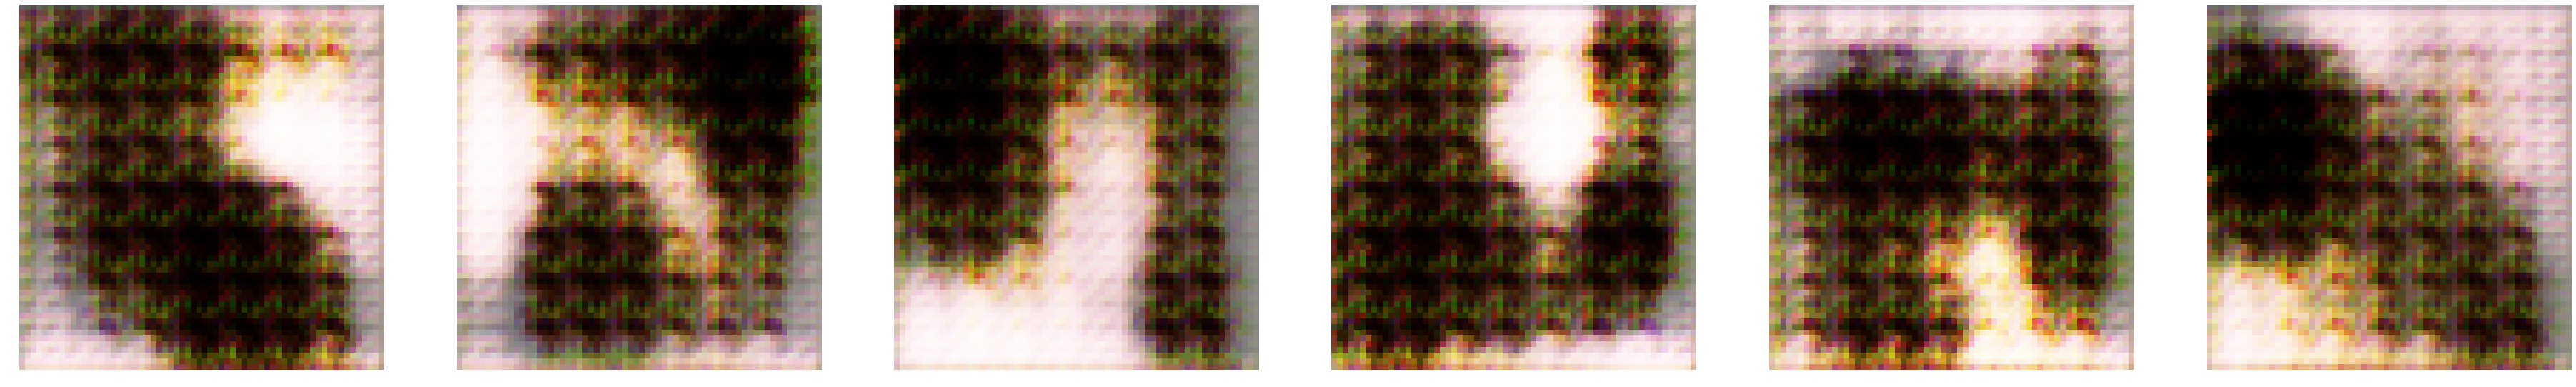

loss=rals 1epochの中での平均値 
 43.68s [2/301] Loss_D: 0.2936 Loss_G: 2.9833 outputR: -0.5866 outputF: -1.0773 / -1.4432
  最後のバッチのloss等 
    43.68s [2/301] Loss_D: 0.1186 Loss_G: 3.0883 outputR: -0.9522 outputF: -1.9696 / -1.8309
loss=rals 1epochの中での平均値 
 43.88s [3/301] Loss_D: 0.2231 Loss_G: 2.9311 outputR: -1.0351 outputF: -1.6223 / -1.8913
  最後のバッチのloss等 
    43.88s [3/301] Loss_D: 0.1836 Loss_G: 3.4823 outputR: -0.8897 outputF: -1.9962 / -1.9332
loss=rals 1epochの中での平均値 
 43.91s [4/301] Loss_D: 0.1916 Loss_G: 2.9113 outputR: -0.7598 outputF: -1.3809 / -1.6148
  最後のバッチのloss等 
    43.91s [4/301] Loss_D: 0.1566 Loss_G: 2.9948 outputR: -0.6620 outputF: -1.1978 / -1.5221
loss=rals 1epochの中での平均値 
 43.78s [5/301] Loss_D: 0.1673 Loss_G: 2.9039 outputR: -0.6062 outputF: -1.2528 / -1.4625
  最後のバッチのloss等 
    43.78s [5/301] Loss_D: 0.5369 Loss_G: 1.2643 outputR: -1.2686 outputF: -1.3992 / -1.5294
loss=rals 1epochの中での平均値 
 43.68s [6/301] Loss_D: 0.1518 Loss_G: 2.7510 outputR: -0.6854 outputF: -1.3509

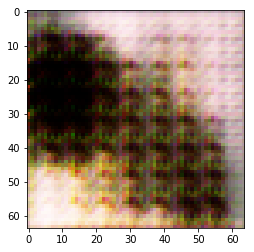

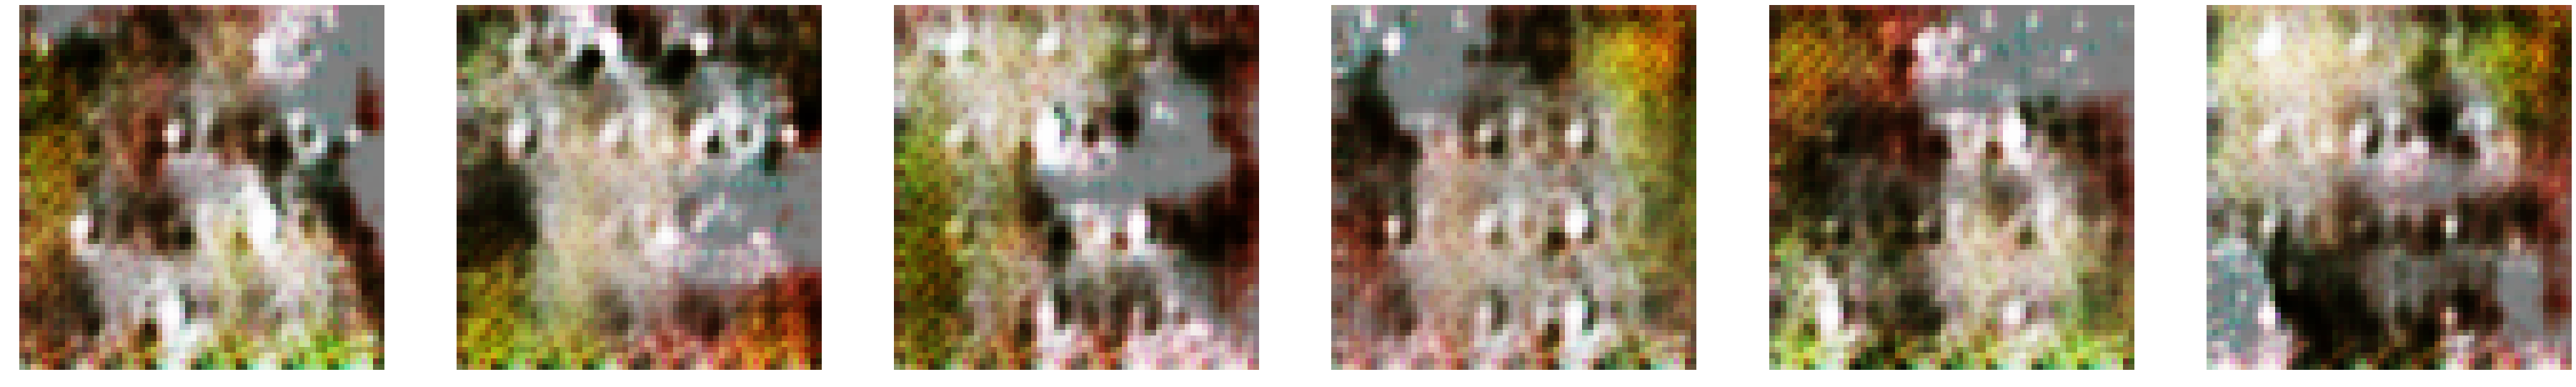

loss=rals 1epochの中での平均値 
 43.65s [12/301] Loss_D: 0.0896 Loss_G: 2.6115 outputR: 0.0560 outputF: -0.6869 / -0.7230
  最後のバッチのloss等 
    43.65s [12/301] Loss_D: 0.0464 Loss_G: 2.3731 outputR: 0.1775 outputF: -0.5803 / -0.5493
loss=rals 1epochの中での平均値 
 43.70s [13/301] Loss_D: 0.0649 Loss_G: 2.6292 outputR: 0.1531 outputF: -0.6189 / -0.6336
  最後のバッチのloss等 
    43.70s [13/301] Loss_D: 0.0845 Loss_G: 2.1317 outputR: -0.6041 outputF: -1.2258 / -1.2319
loss=rals 1epochの中での平均値 
 43.69s [14/301] Loss_D: 0.0981 Loss_G: 2.5947 outputR: -0.6430 outputF: -1.3685 / -1.4149
  最後のバッチのloss等 
    43.69s [14/301] Loss_D: 0.0598 Loss_G: 1.8394 outputR: -1.0967 outputF: -1.8157 / -1.6386
loss=rals 1epochの中での平均値 
 43.66s [15/301] Loss_D: 0.0924 Loss_G: 2.5606 outputR: -0.5218 outputF: -1.2496 / -1.2832
  最後のバッチのloss等 
    43.66s [15/301] Loss_D: 0.0699 Loss_G: 2.8393 outputR: -0.6167 outputF: -1.4295 / -1.4964
loss=rals 1epochの中での平均値 
 43.70s [16/301] Loss_D: 0.1383 Loss_G: 2.8875 outputR: -0.3688 outputF: -

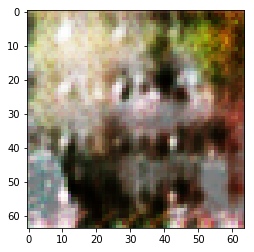

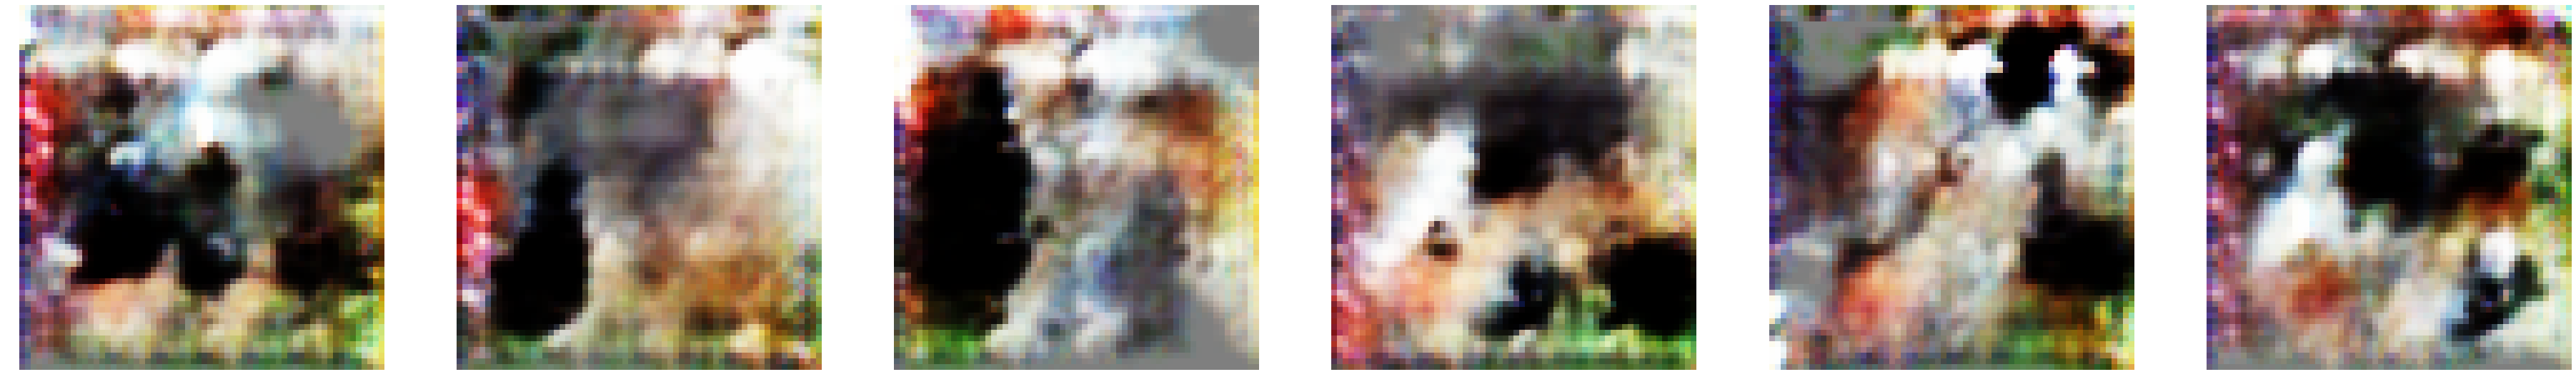

loss=rals 1epochの中での平均値 
 43.95s [22/301] Loss_D: 0.0937 Loss_G: 2.7444 outputR: -0.1975 outputF: -0.9362 / -1.0200
  最後のバッチのloss等 
    43.95s [22/301] Loss_D: 0.0900 Loss_G: 2.7329 outputR: -0.7136 outputF: -1.6030 / -1.5730
loss=rals 1epochの中での平均値 
 43.65s [23/301] Loss_D: 0.1073 Loss_G: 2.6555 outputR: -0.5408 outputF: -1.2447 / -1.3283
  最後のバッチのloss等 
    43.65s [23/301] Loss_D: 0.0603 Loss_G: 2.8877 outputR: -0.3216 outputF: -1.2594 / -1.1785
loss=rals 1epochの中での平均値 
 44.31s [24/301] Loss_D: 0.1242 Loss_G: 2.6684 outputR: -0.6595 outputF: -1.3503 / -1.4520
  最後のバッチのloss等 
    44.32s [24/301] Loss_D: 0.1587 Loss_G: 4.0718 outputR: -0.4539 outputF: -0.9389 / -1.6202
loss=rals 1epochの中での平均値 
 43.57s [25/301] Loss_D: 0.1126 Loss_G: 2.6259 outputR: -0.6287 outputF: -1.3380 / -1.4069
  最後のバッチのloss等 
    43.57s [25/301] Loss_D: 0.0609 Loss_G: 3.0209 outputR: -0.3965 outputF: -1.2160 / -1.3288
loss=rals 1epochの中での平均値 
 43.73s [26/301] Loss_D: 0.1118 Loss_G: 2.5318 outputR: -0.6606 outputF

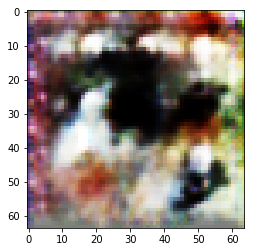

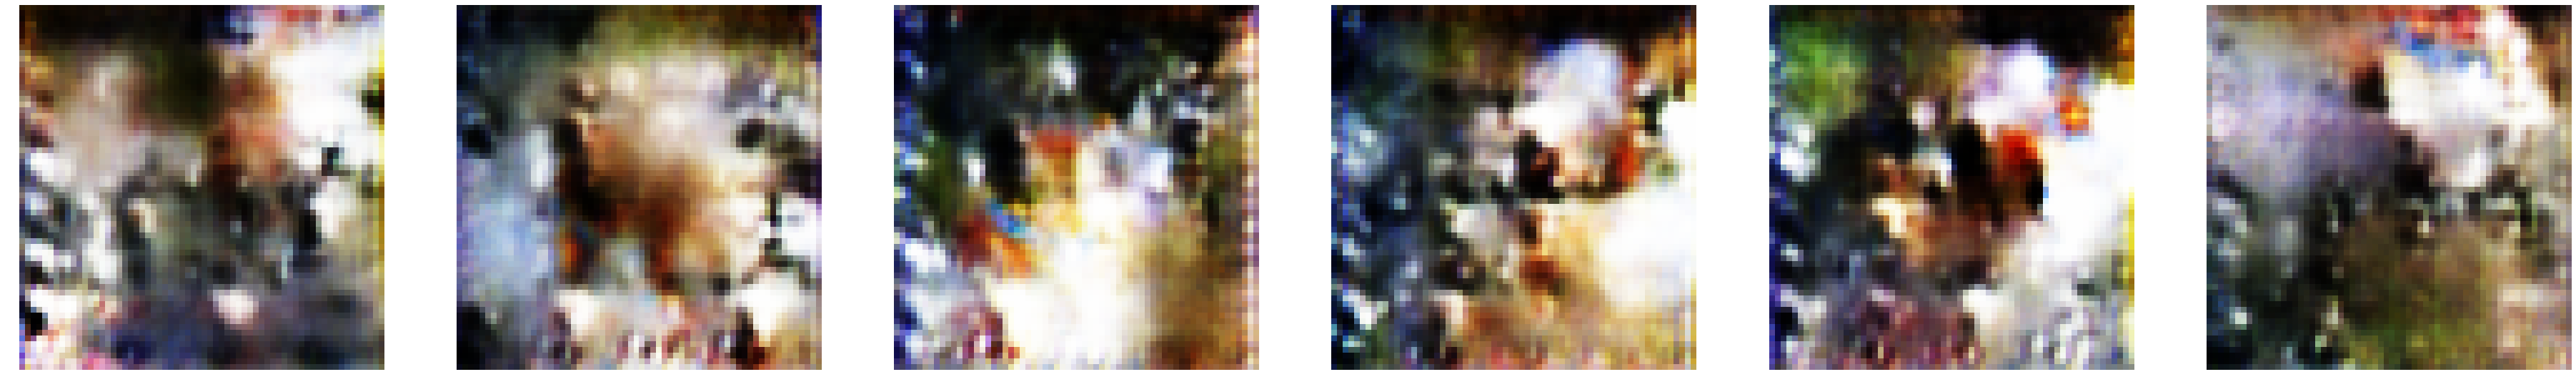

loss=rals 1epochの中での平均値 
 43.84s [32/301] Loss_D: 0.1180 Loss_G: 2.7462 outputR: -0.3836 outputF: -1.0962 / -1.1997
  最後のバッチのloss等 
    43.84s [32/301] Loss_D: 0.0939 Loss_G: 3.0302 outputR: -0.3370 outputF: -0.9428 / -1.2589
loss=rals 1epochの中での平均値 
 43.97s [33/301] Loss_D: 0.1080 Loss_G: 2.7439 outputR: -0.3361 outputF: -1.0559 / -1.1516
  最後のバッチのloss等 
    43.97s [33/301] Loss_D: 0.0759 Loss_G: 2.6709 outputR: -0.3657 outputF: -1.0577 / -1.1655
loss=rals 1epochの中での平均値 
 43.80s [34/301] Loss_D: 0.1018 Loss_G: 2.7614 outputR: -0.2529 outputF: -0.9833 / -1.0740
  最後のバッチのloss等 
    43.81s [34/301] Loss_D: 0.1064 Loss_G: 2.4630 outputR: -0.3556 outputF: -0.9127 / -1.1057
loss=rals 1epochの中での平均値 
 43.83s [35/301] Loss_D: 0.1012 Loss_G: 2.7462 outputR: -0.3555 outputF: -1.0805 / -1.1732
  最後のバッチのloss等 
    43.83s [35/301] Loss_D: 0.0430 Loss_G: 3.0516 outputR: 0.1285 outputF: -0.7980 / -0.7689
loss=rals 1epochの中での平均値 
 43.79s [36/301] Loss_D: 0.1006 Loss_G: 2.7162 outputR: -0.2597 outputF:

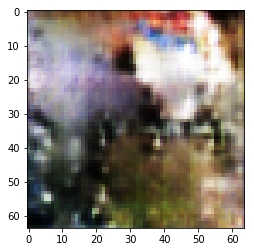

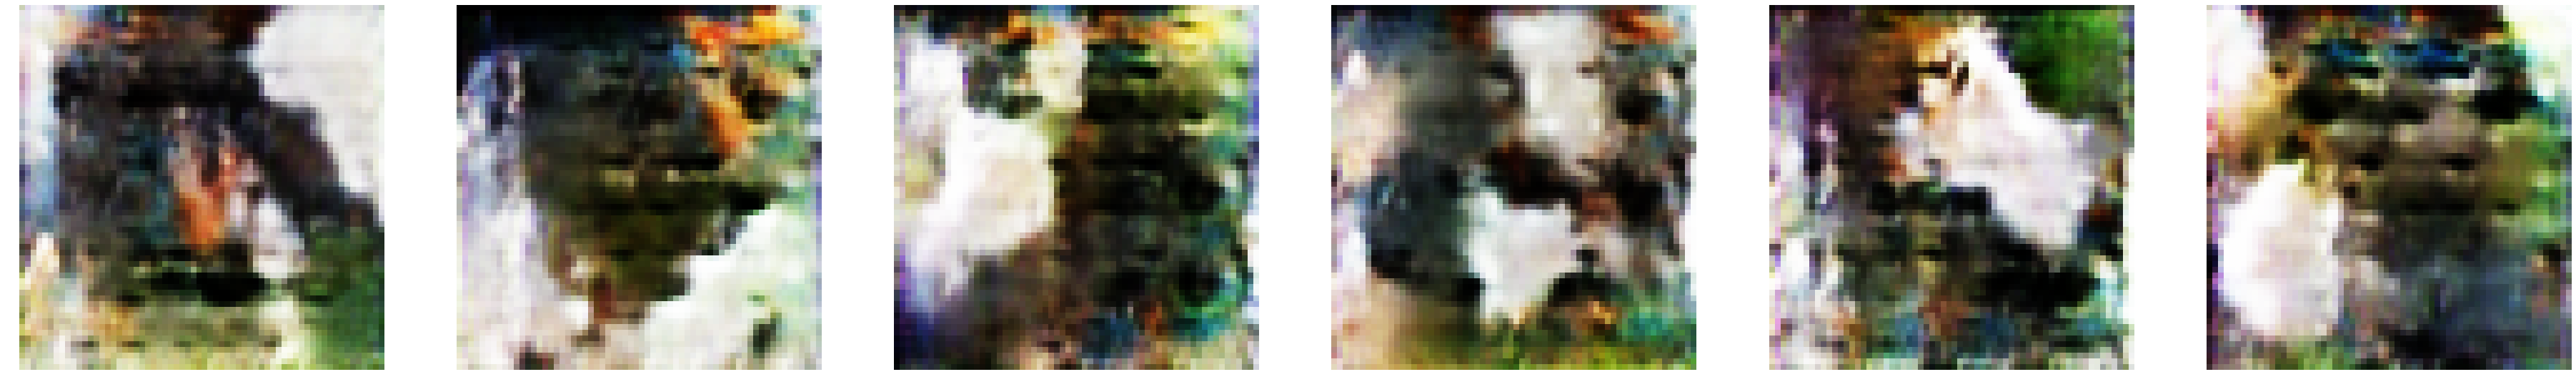

loss=rals 1epochの中での平均値 
 43.44s [42/301] Loss_D: 0.0783 Loss_G: 2.5976 outputR: -0.2200 outputF: -0.9698 / -0.9957
  最後のバッチのloss等 
    43.44s [42/301] Loss_D: 0.2209 Loss_G: 2.0135 outputR: -0.7304 outputF: -1.1110 / -1.3521
loss=rals 1epochの中での平均値 
 43.28s [43/301] Loss_D: 0.0734 Loss_G: 2.5756 outputR: -0.2304 outputF: -0.9825 / -0.9983
  最後のバッチのloss等 
    43.28s [43/301] Loss_D: 0.0364 Loss_G: 2.2149 outputR: -0.3153 outputF: -1.1234 / -0.9776
loss=rals 1epochの中での平均値 
 43.46s [44/301] Loss_D: 0.0796 Loss_G: 2.5493 outputR: -0.2913 outputF: -1.0345 / -1.0528
  最後のバッチのloss等 
    43.46s [44/301] Loss_D: 0.0586 Loss_G: 2.8163 outputR: -0.2011 outputF: -0.9893 / -1.0950
loss=rals 1epochの中での平均値 
 43.60s [45/301] Loss_D: 0.0813 Loss_G: 2.5081 outputR: -0.2805 outputF: -1.0235 / -1.0259
  最後のバッチのloss等 
    43.60s [45/301] Loss_D: 0.0292 Loss_G: 3.2849 outputR: -0.1582 outputF: -0.9872 / -1.1044
loss=rals 1epochの中での平均値 
 43.39s [46/301] Loss_D: 0.1099 Loss_G: 2.8805 outputR: -0.2051 outputF

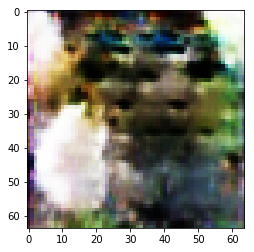

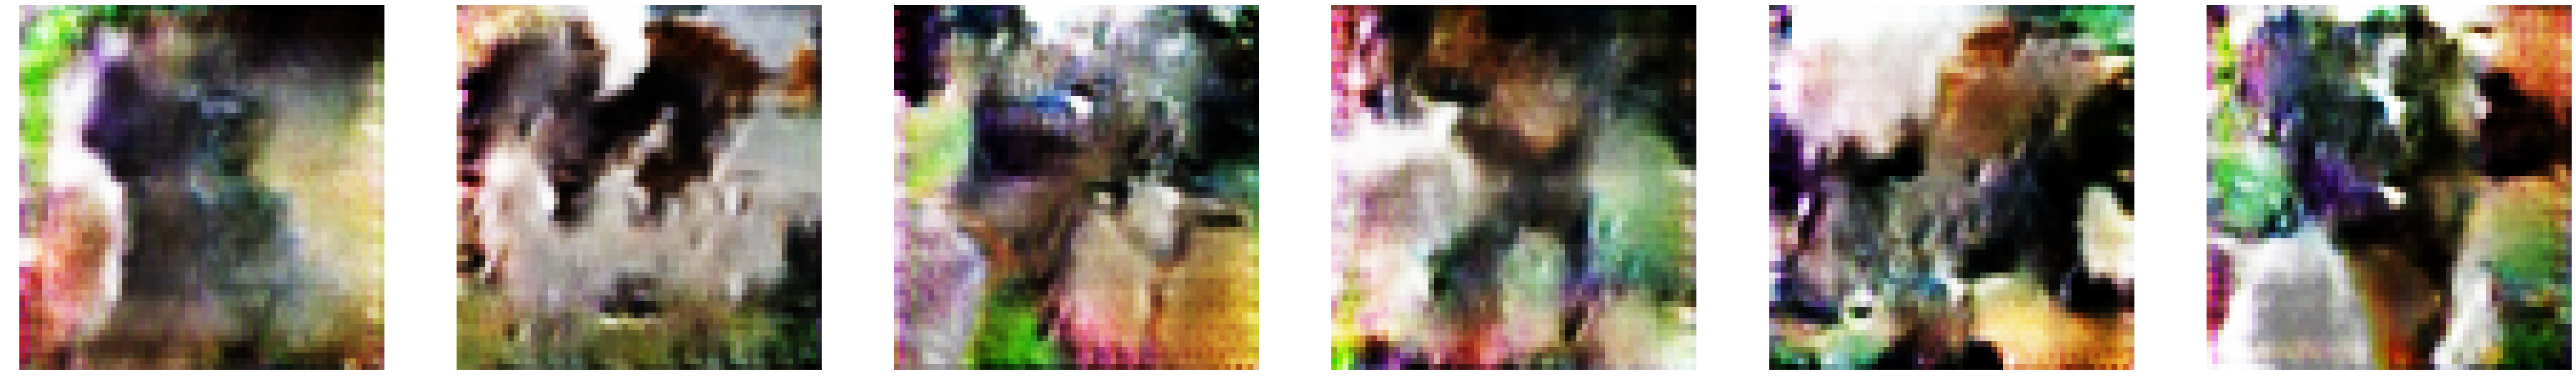

loss=rals 1epochの中での平均値 
 43.87s [52/301] Loss_D: 0.0955 Loss_G: 2.6190 outputR: -0.3019 outputF: -1.0361 / -1.0823
  最後のバッチのloss等 
    43.87s [52/301] Loss_D: 0.2096 Loss_G: 2.6483 outputR: 0.0069 outputF: -1.2221 / -0.7753
loss=rals 1epochの中での平均値 
 43.62s [53/301] Loss_D: 0.0875 Loss_G: 2.6139 outputR: -0.2837 outputF: -1.0235 / -1.0629
  最後のバッチのloss等 
    43.62s [53/301] Loss_D: 0.0283 Loss_G: 3.2686 outputR: -0.3158 outputF: -1.0698 / -1.2856
loss=rals 1epochの中での平均値 
 43.50s [54/301] Loss_D: 0.0844 Loss_G: 2.6138 outputR: -0.2541 outputF: -0.9993 / -1.0339
  最後のバッチのloss等 
    43.50s [54/301] Loss_D: 0.1247 Loss_G: 2.2267 outputR: -0.3676 outputF: -0.9341 / -1.0540
loss=rals 1epochの中での平均値 
 43.55s [55/301] Loss_D: 0.0806 Loss_G: 2.5813 outputR: -0.2002 outputF: -0.9480 / -0.9697
  最後のバッチのloss等 
    43.55s [55/301] Loss_D: 0.0890 Loss_G: 2.1555 outputR: -0.3605 outputF: -0.9542 / -1.0231
loss=rals 1epochの中での平均値 
 43.44s [56/301] Loss_D: 0.0811 Loss_G: 2.5555 outputR: -0.1924 outputF:

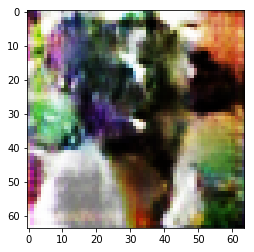

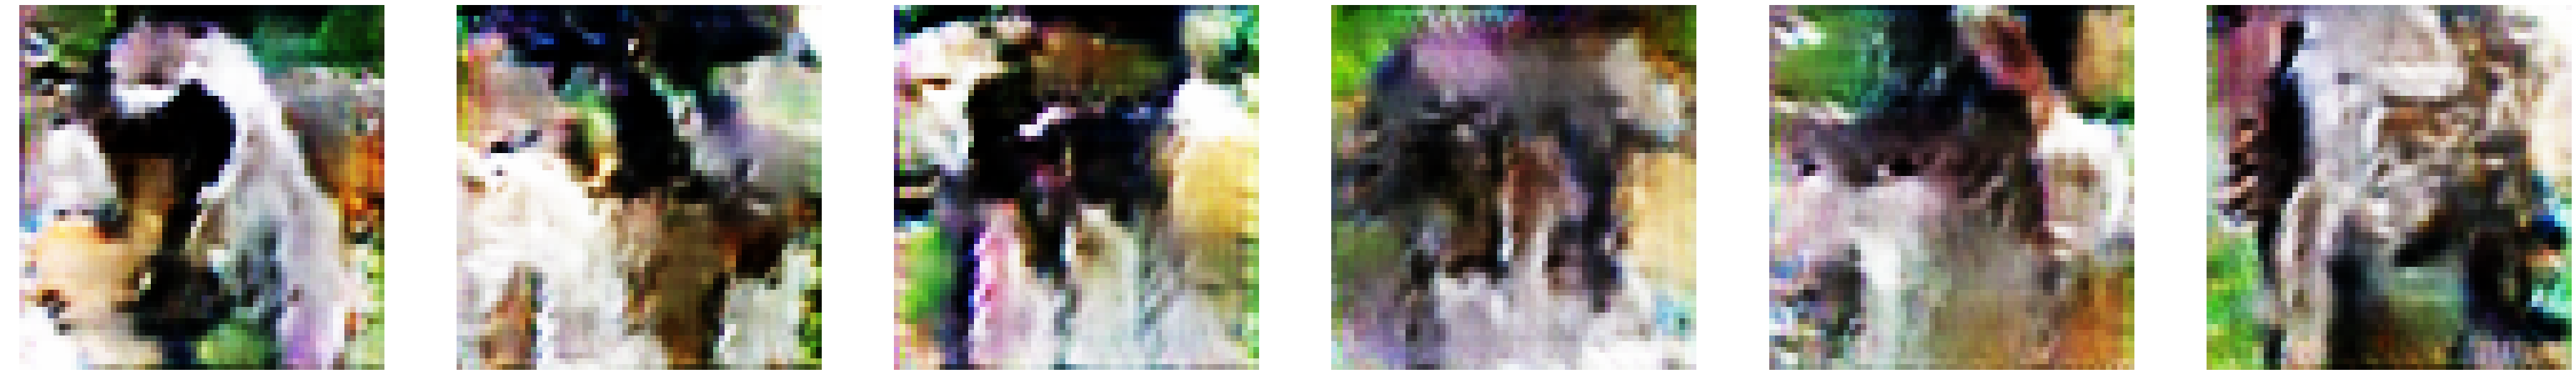

loss=rals 1epochの中での平均値 
 43.62s [62/301] Loss_D: 0.0941 Loss_G: 2.6297 outputR: -0.2282 outputF: -0.9671 / -1.0110
  最後のバッチのloss等 
    43.62s [62/301] Loss_D: 0.0638 Loss_G: 2.5123 outputR: 0.0959 outputF: -0.6798 / -0.6912
loss=rals 1epochの中での平均値 
 43.48s [63/301] Loss_D: 0.0927 Loss_G: 2.6585 outputR: -0.2169 outputF: -0.9546 / -1.0089
  最後のバッチのloss等 
    43.48s [63/301] Loss_D: 0.0345 Loss_G: 2.8528 outputR: -0.3275 outputF: -1.1160 / -1.1799
loss=rals 1epochの中での平均値 
 43.42s [64/301] Loss_D: 0.0936 Loss_G: 2.6369 outputR: -0.2244 outputF: -0.9631 / -1.0094
  最後のバッチのloss等 
    43.42s [64/301] Loss_D: 0.0606 Loss_G: 2.3117 outputR: 0.0691 outputF: -0.6383 / -0.6283
loss=rals 1epochの中での平均値 
 43.42s [65/301] Loss_D: 0.0905 Loss_G: 2.6214 outputR: -0.1498 outputF: -0.8901 / -0.9311
  最後のバッチのloss等 
    43.42s [65/301] Loss_D: 0.1200 Loss_G: 2.3046 outputR: -0.3508 outputF: -0.9169 / -1.0540
loss=rals 1epochの中での平均値 
 43.83s [66/301] Loss_D: 0.0830 Loss_G: 2.6275 outputR: -0.1951 outputF: 

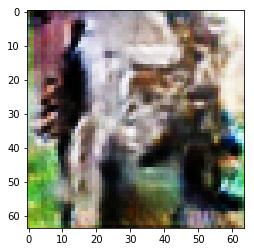

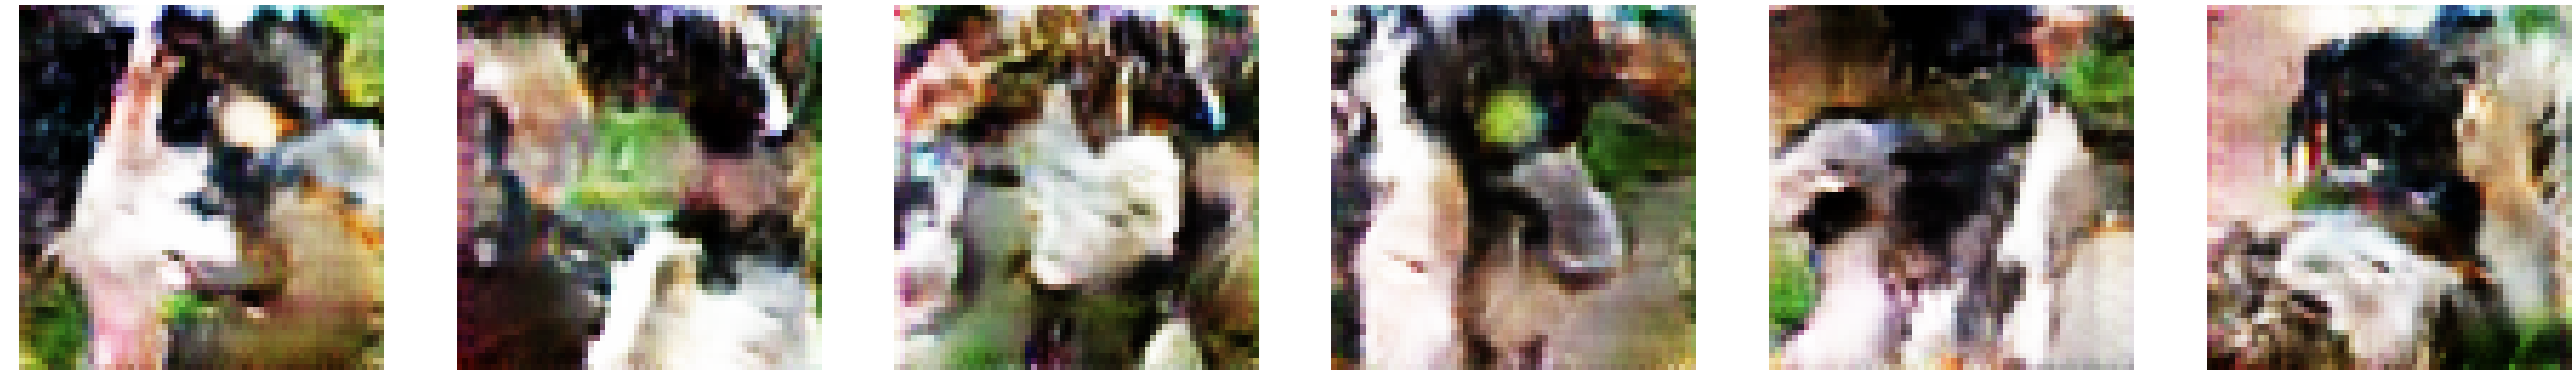

loss=rals 1epochの中での平均値 
 43.38s [72/301] Loss_D: 0.0737 Loss_G: 2.5571 outputR: -0.1433 outputF: -0.8953 / -0.9071
  最後のバッチのloss等 
    43.38s [72/301] Loss_D: 0.0208 Loss_G: 2.6075 outputR: -0.0933 outputF: -0.9861 / -0.8483
loss=rals 1epochの中での平均値 
 43.76s [73/301] Loss_D: 0.0745 Loss_G: 2.5174 outputR: -0.2492 outputF: -0.9946 / -1.0016
  最後のバッチのloss等 
    43.76s [73/301] Loss_D: 0.1120 Loss_G: 3.1313 outputR: -0.1038 outputF: -1.1548 / -1.0608
loss=rals 1epochの中での平均値 
 43.72s [74/301] Loss_D: 0.0734 Loss_G: 2.5192 outputR: -0.2889 outputF: -1.0352 / -1.0397
  最後のバッチのloss等 
    43.72s [74/301] Loss_D: 0.0298 Loss_G: 3.1328 outputR: -0.1316 outputF: -1.0598 / -1.0434
loss=rals 1epochの中での平均値 
 43.53s [75/301] Loss_D: 0.0799 Loss_G: 2.4956 outputR: -0.3653 outputF: -1.1029 / -1.1083
  最後のバッチのloss等 
    43.53s [75/301] Loss_D: 0.1078 Loss_G: 3.0684 outputR: -0.3024 outputF: -1.2924 / -1.2555
loss=rals 1epochの中での平均値 
 43.45s [76/301] Loss_D: 0.1110 Loss_G: 2.7125 outputR: -0.1069 outputF

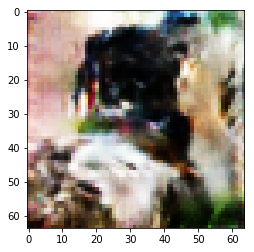

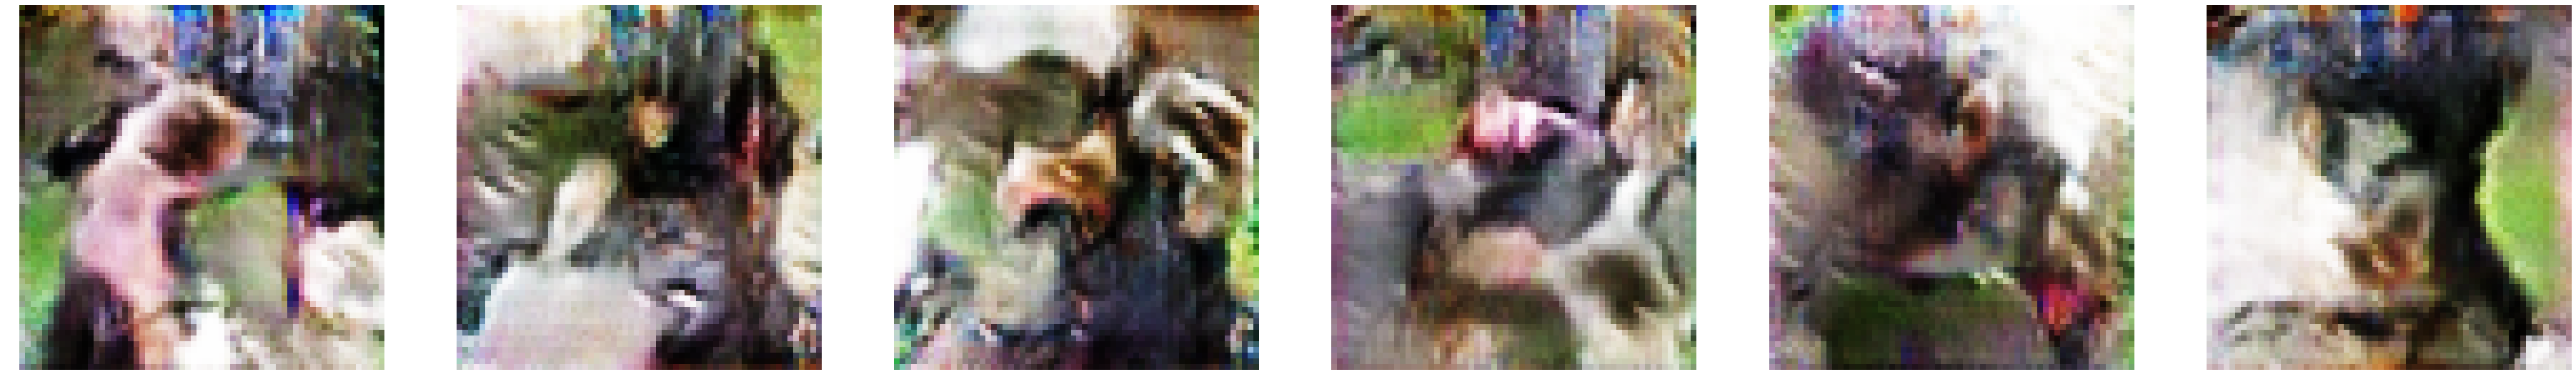

loss=rals 1epochの中での平均値 
 43.37s [82/301] Loss_D: 0.0755 Loss_G: 2.6279 outputR: -0.0971 outputF: -0.8552 / -0.8818
  最後のバッチのloss等 
    43.37s [82/301] Loss_D: 0.0529 Loss_G: 3.0694 outputR: 0.0940 outputF: -0.6245 / -0.8079
loss=rals 1epochの中での平均値 
 43.22s [83/301] Loss_D: 0.0737 Loss_G: 2.6088 outputR: -0.1109 outputF: -0.8694 / -0.8917
  最後のバッチのloss等 
    43.22s [83/301] Loss_D: 0.0864 Loss_G: 2.5957 outputR: -0.2436 outputF: -0.8569 / -1.0564
loss=rals 1epochの中での平均値 
 43.17s [84/301] Loss_D: 0.0732 Loss_G: 2.5808 outputR: -0.0541 outputF: -0.8134 / -0.8258
  最後のバッチのloss等 
    43.17s [84/301] Loss_D: 0.0464 Loss_G: 2.8620 outputR: -0.0690 outputF: -0.7860 / -0.9233
loss=rals 1epochの中での平均値 
 43.30s [85/301] Loss_D: 0.0709 Loss_G: 2.5845 outputR: -0.1750 outputF: -0.9347 / -0.9481
  最後のバッチのloss等 
    43.30s [85/301] Loss_D: 0.0308 Loss_G: 3.1899 outputR: -0.0020 outputF: -0.7930 / -0.9661
loss=rals 1epochの中での平均値 
 43.31s [86/301] Loss_D: 0.0713 Loss_G: 2.5564 outputR: -0.1143 outputF:

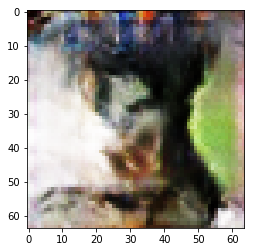

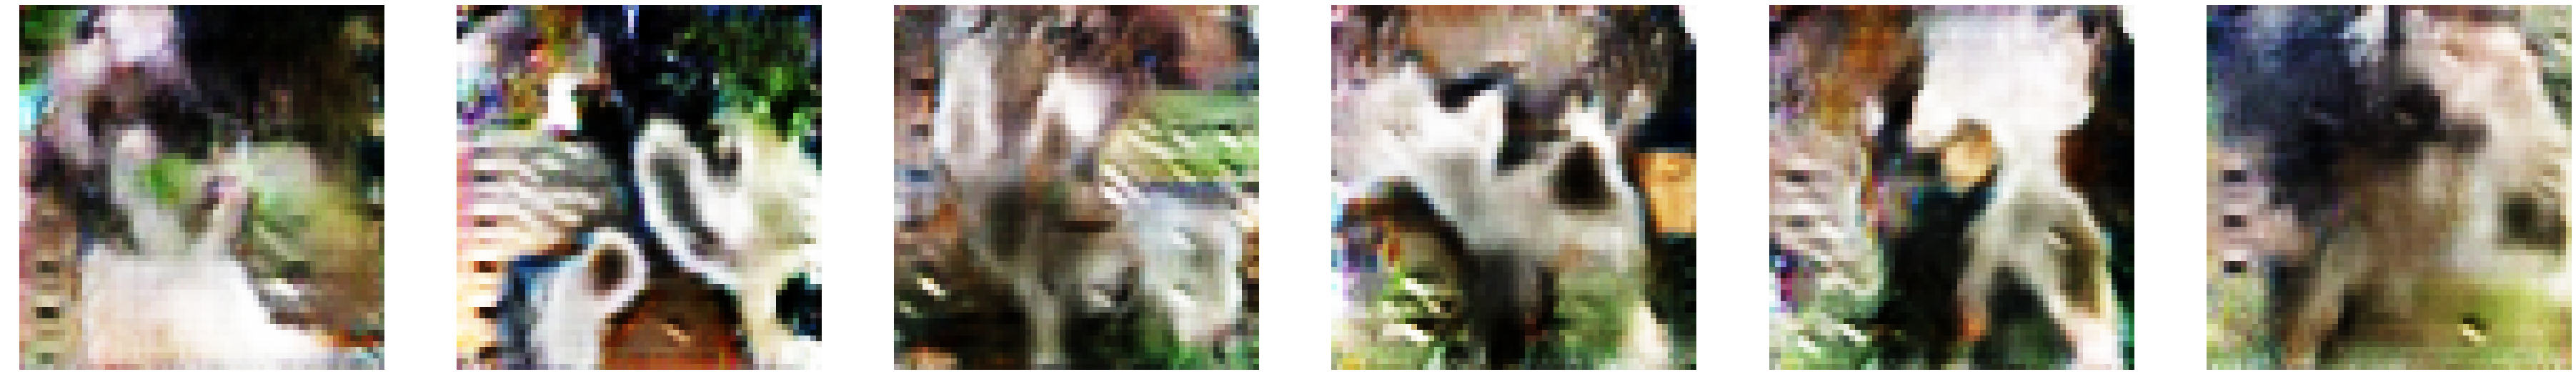

loss=rals 1epochの中での平均値 
 43.21s [92/301] Loss_D: 0.0862 Loss_G: 2.6493 outputR: -0.0220 outputF: -0.7702 / -0.8141
  最後のバッチのloss等 
    43.21s [92/301] Loss_D: 0.0178 Loss_G: 2.6967 outputR: 0.0380 outputF: -0.8184 / -0.7459
loss=rals 1epochの中での平均値 
 43.10s [93/301] Loss_D: 0.0778 Loss_G: 2.6468 outputR: 0.0466 outputF: -0.7120 / -0.7443
  最後のバッチのloss等 
    43.10s [93/301] Loss_D: 0.0823 Loss_G: 2.4503 outputR: 0.0516 outputF: -0.6841 / -0.7119
loss=rals 1epochの中での平均値 
 43.23s [94/301] Loss_D: 0.0807 Loss_G: 2.6385 outputR: 0.0187 outputF: -0.7369 / -0.7696
  最後のバッチのloss等 
    43.23s [94/301] Loss_D: 0.0494 Loss_G: 2.9524 outputR: -0.0926 outputF: -1.0322 / -0.9807
loss=rals 1epochの中での平均値 
 43.22s [95/301] Loss_D: 0.0709 Loss_G: 2.6204 outputR: 0.0173 outputF: -0.7500 / -0.7679
  最後のバッチのloss等 
    43.22s [95/301] Loss_D: 0.0795 Loss_G: 2.5401 outputR: 0.1613 outputF: -0.7298 / -0.6383
loss=rals 1epochの中での平均値 
 43.13s [96/301] Loss_D: 0.0696 Loss_G: 2.6395 outputR: 0.1671 outputF: -0.59

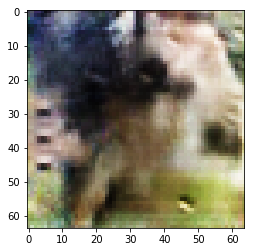

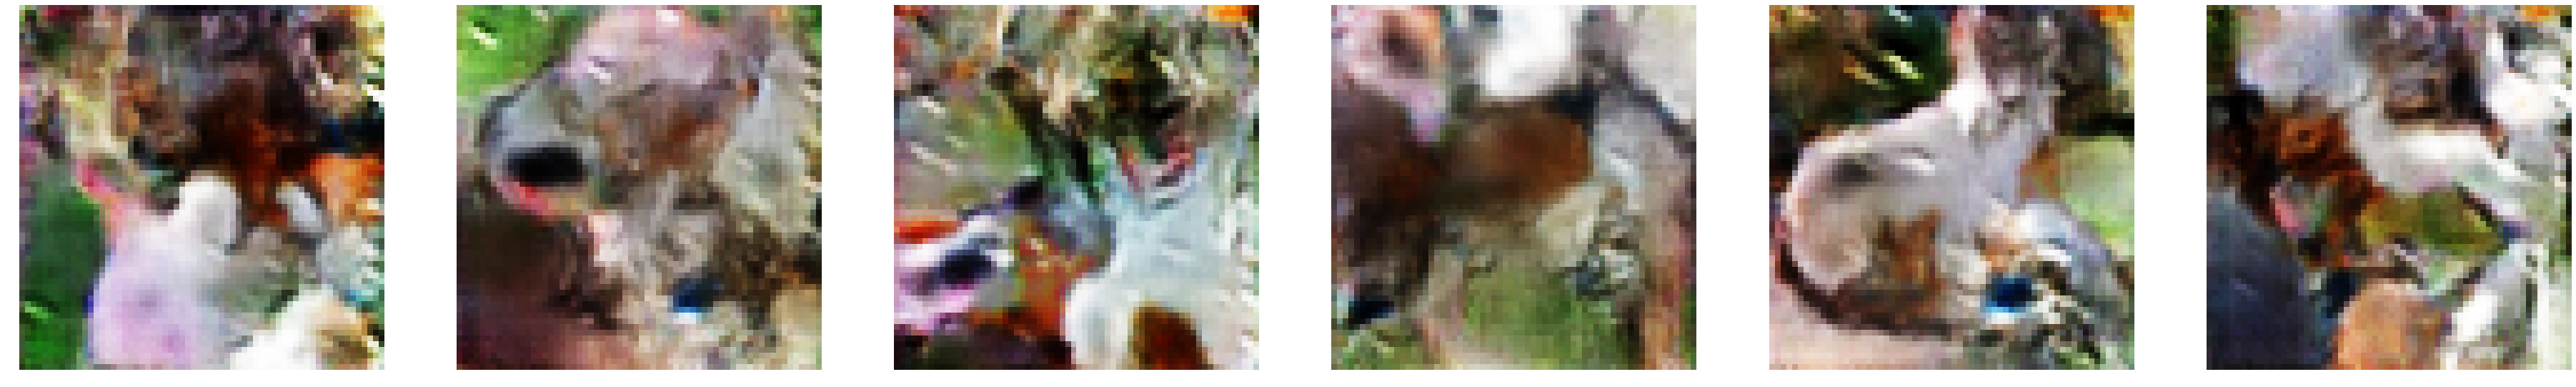

loss=rals 1epochの中での平均値 
 43.44s [102/301] Loss_D: 0.0652 Loss_G: 2.5626 outputR: 0.0570 outputF: -0.7050 / -0.7097
  最後のバッチのloss等 
    43.44s [102/301] Loss_D: 0.0866 Loss_G: 2.2161 outputR: -0.0860 outputF: -0.6876 / -0.7319
loss=rals 1epochの中での平均値 
 43.34s [103/301] Loss_D: 0.0652 Loss_G: 2.5536 outputR: 0.0511 outputF: -0.7066 / -0.7140
  最後のバッチのloss等 
    43.34s [103/301] Loss_D: 0.0594 Loss_G: 2.4464 outputR: 0.1128 outputF: -0.7428 / -0.6672
loss=rals 1epochの中での平均値 
 43.28s [104/301] Loss_D: 0.0687 Loss_G: 2.4800 outputR: 0.0656 outputF: -0.6759 / -0.6734
  最後のバッチのloss等 
    43.28s [104/301] Loss_D: 0.0427 Loss_G: 2.2669 outputR: 0.0222 outputF: -0.7440 / -0.6531
loss=rals 1epochの中での平均値 
 43.41s [105/301] Loss_D: 0.0671 Loss_G: 2.5110 outputR: -0.0627 outputF: -0.8076 / -0.8119
  最後のバッチのloss等 
    43.41s [105/301] Loss_D: 0.1081 Loss_G: 2.3370 outputR: -0.2151 outputF: -0.7698 / -0.9258
loss=rals 1epochの中での平均値 
 43.19s [106/301] Loss_D: 0.0863 Loss_G: 2.6701 outputR: 0.2686 outp

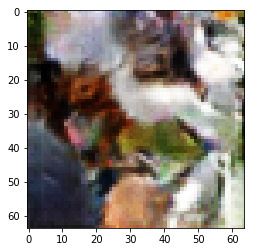

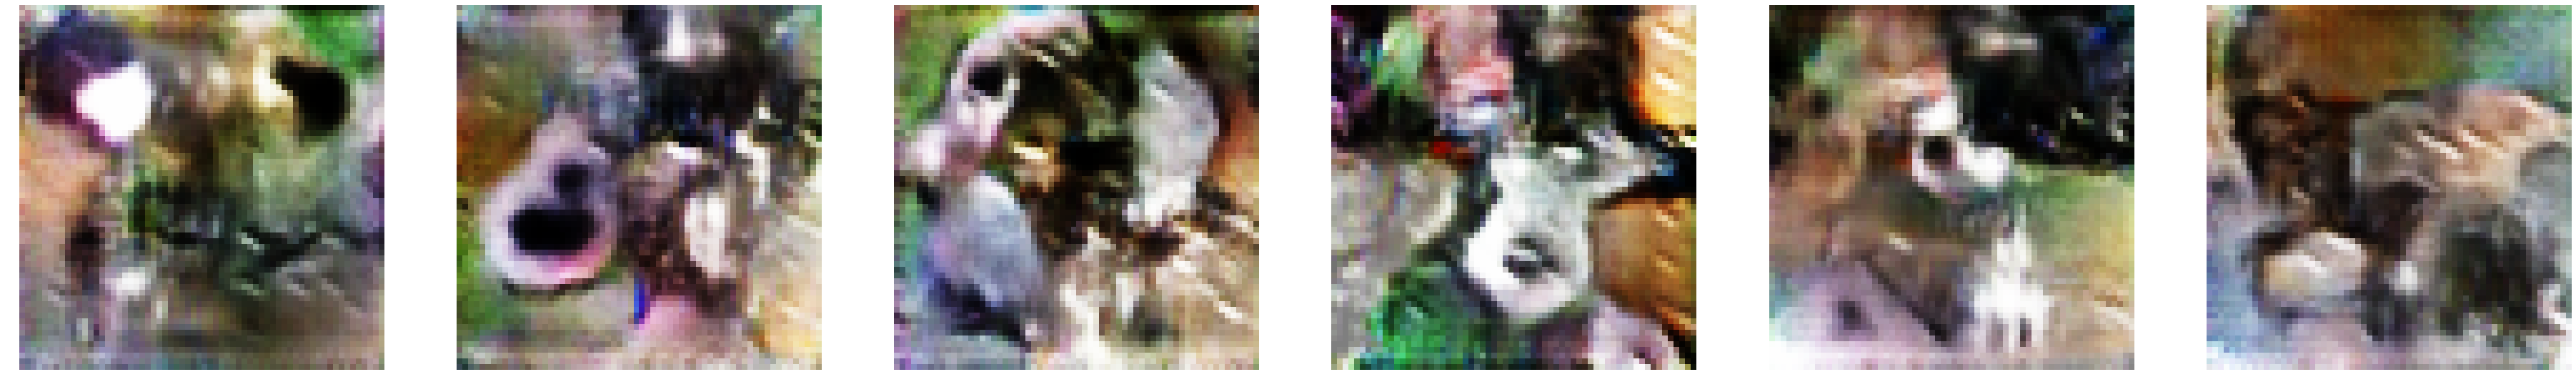

loss=rals 1epochの中での平均値 
 43.35s [112/301] Loss_D: 0.0649 Loss_G: 2.6173 outputR: 0.2645 outputF: -0.5073 / -0.5199
  最後のバッチのloss等 
    43.35s [112/301] Loss_D: 0.0540 Loss_G: 3.5974 outputR: 0.2450 outputF: -0.7513 / -0.8182
loss=rals 1epochの中での平均値 
 43.21s [113/301] Loss_D: 0.0630 Loss_G: 2.6169 outputR: 0.2769 outputF: -0.4952 / -0.5067
  最後のバッチのloss等 
    43.21s [113/301] Loss_D: 0.0648 Loss_G: 2.5954 outputR: 0.5403 outputF: -0.3884 / -0.2758
loss=rals 1epochの中での平均値 
 43.18s [114/301] Loss_D: 0.0602 Loss_G: 2.6389 outputR: 0.2751 outputF: -0.5015 / -0.5143
  最後のバッチのloss等 
    43.18s [114/301] Loss_D: 0.0579 Loss_G: 3.0633 outputR: 0.4019 outputF: -0.6576 / -0.4977
loss=rals 1epochの中での平均値 
 43.54s [115/301] Loss_D: 0.0621 Loss_G: 2.6011 outputR: 0.2138 outputF: -0.5570 / -0.5663
  最後のバッチのloss等 
    43.54s [115/301] Loss_D: 0.0462 Loss_G: 3.1435 outputR: 0.5380 outputF: -0.3595 / -0.4059
loss=rals 1epochの中での平均値 
 43.19s [116/301] Loss_D: 0.0629 Loss_G: 2.5968 outputR: 0.3098 outputF

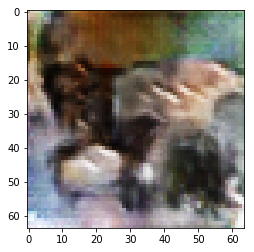

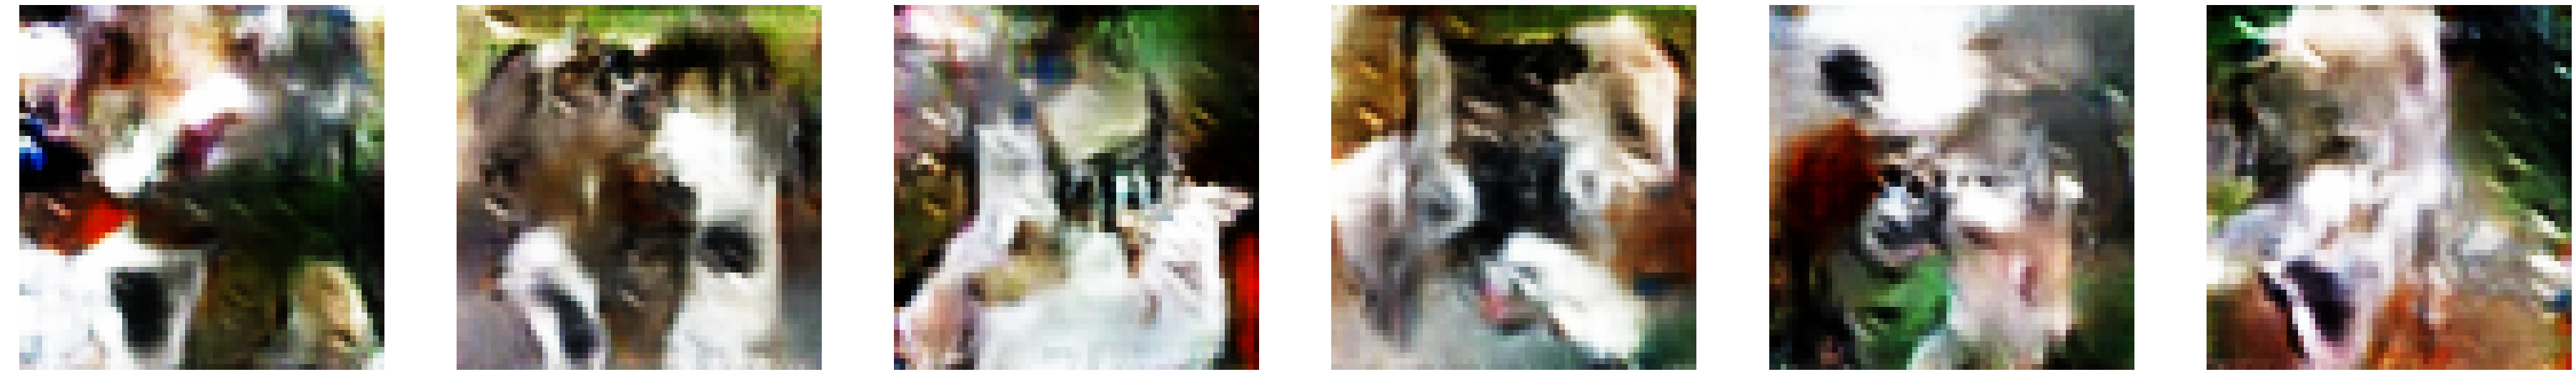

loss=rals 1epochの中での平均値 
 43.56s [122/301] Loss_D: 0.0729 Loss_G: 2.6525 outputR: 0.4030 outputF: -0.3633 / -0.3911
  最後のバッチのloss等 
    43.56s [122/301] Loss_D: 0.0981 Loss_G: 2.3769 outputR: 0.2507 outputF: -0.3545 / -0.4863
loss=rals 1epochの中での平均値 
 43.19s [123/301] Loss_D: 0.0652 Loss_G: 2.6388 outputR: 0.4111 outputF: -0.3633 / -0.3819
  最後のバッチのloss等 
    43.19s [123/301] Loss_D: 0.0709 Loss_G: 2.7541 outputR: 0.3253 outputF: -0.5581 / -0.5481
loss=rals 1epochの中での平均値 
 43.16s [124/301] Loss_D: 0.0640 Loss_G: 2.6493 outputR: 0.4612 outputF: -0.3125 / -0.3341
  最後のバッチのloss等 
    43.16s [124/301] Loss_D: 0.0536 Loss_G: 2.5428 outputR: 0.5407 outputF: -0.1423 / -0.2295
loss=rals 1epochの中での平均値 
 43.05s [125/301] Loss_D: 0.0658 Loss_G: 2.6312 outputR: 0.4192 outputF: -0.3524 / -0.3705
  最後のバッチのloss等 
    43.05s [125/301] Loss_D: 0.0625 Loss_G: 2.5542 outputR: 0.5116 outputF: -0.2999 / -0.2748
loss=rals 1epochの中での平均値 
 43.16s [126/301] Loss_D: 0.0621 Loss_G: 2.6359 outputR: 0.4278 outputF

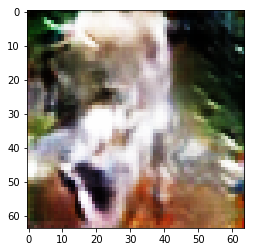

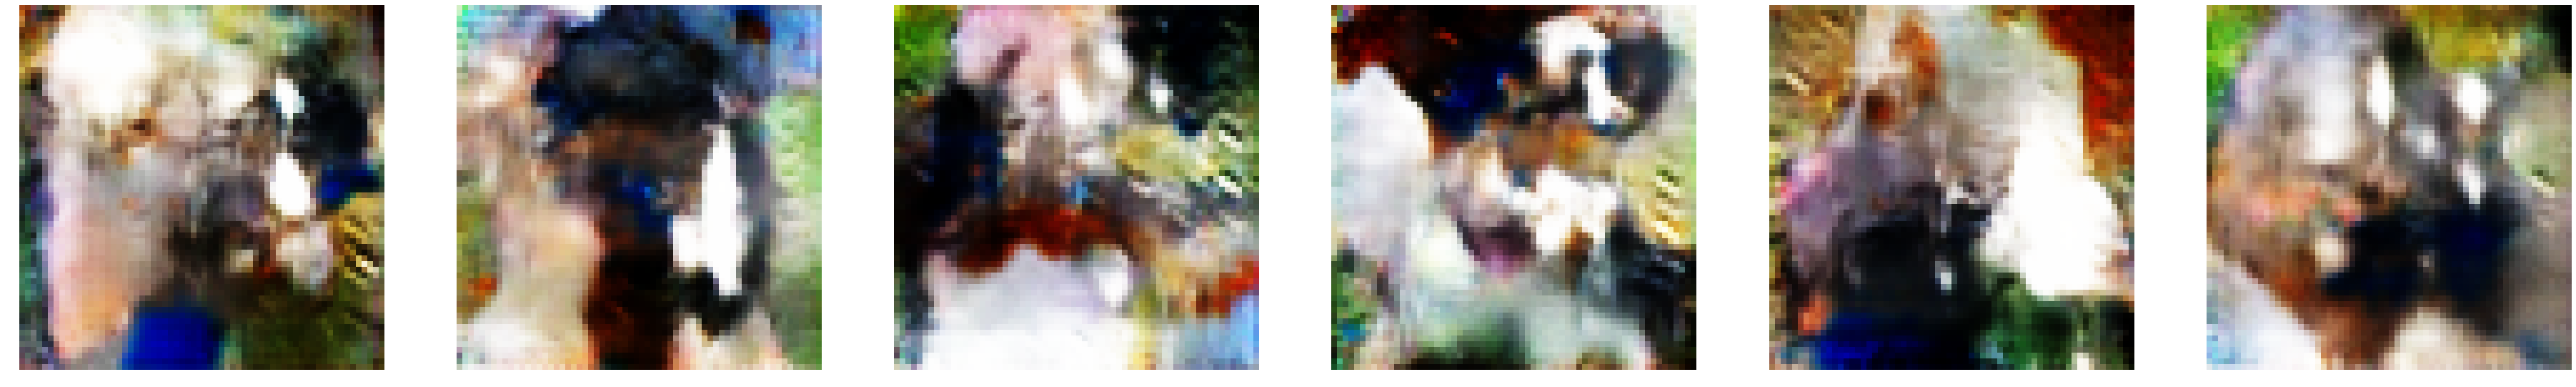

loss=rals 1epochの中での平均値 
 43.10s [132/301] Loss_D: 0.0549 Loss_G: 2.5878 outputR: 0.3724 outputF: -0.4048 / -0.4048
  最後のバッチのloss等 
    43.10s [132/301] Loss_D: 0.0240 Loss_G: 2.9972 outputR: 0.3838 outputF: -0.4463 / -0.5147
loss=rals 1epochの中での平均値 
 43.20s [133/301] Loss_D: 0.0590 Loss_G: 2.5873 outputR: 0.3622 outputF: -0.4087 / -0.4153
  最後のバッチのloss等 
    43.20s [133/301] Loss_D: 0.0204 Loss_G: 3.1985 outputR: 0.3691 outputF: -0.3976 / -0.5778
loss=rals 1epochの中での平均値 
 43.27s [134/301] Loss_D: 0.0629 Loss_G: 2.5345 outputR: 0.2995 outputF: -0.4590 / -0.4597
  最後のバッチのloss等 
    43.27s [134/301] Loss_D: 0.0262 Loss_G: 3.3467 outputR: 0.2722 outputF: -0.5703 / -0.7242


In [ ]:
import gc
torch.backends.cudnn.benchmark = True

d_loss_log = []
g_loss_log = []
dout_real_log = []
dout_fake_log = []
dout_fake_log2 = []

iter_n = len(train_loader) - 1 #最後の余ったバッチは計算されないから-1

for epoch in range(epochs):
    
    epoch_g_loss = 0.0  # epochの損失和
    epoch_d_loss = 0.0  # epochの損失和
    epoch_dout_real = 0.0
    epoch_dout_fake = 0.0
    epoch_dout_fake2 = 0.0

    epoch_time = time.perf_counter()
    if time.perf_counter() - kernel_start_time > 31000:
            print("Time limit reached! Stopping kernel!"); break

    for ii, (real_images, dog_labels) in enumerate(train_loader):
        if real_images.shape[0]!= BATCH_SIZE: continue
        
        # ラベルにノイズを入れる。そして時々fakeとrealを入れ替える。
        if use_soft_noisy_labels:
            real_labels = torch.squeeze(torch.empty((BATCH_SIZE, 1), device=device).uniform_(*R_uni))
            fake_labels = torch.squeeze(torch.empty((BATCH_SIZE, 1), device=device).uniform_(*F_uni))
            for p in np.random.choice(BATCH_SIZE, size=np.random.randint((BATCH_SIZE//8)), replace=False):
                real_labels[p], fake_labels[p] = fake_labels[p], real_labels[p] # swap labels
        else:
            real_labels = torch.full((BATCH_SIZE, 1), 1.0, device=device)
            fake_labels = torch.full((BATCH_SIZE, 1), 0.0, device=device)
        
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()

        dog_labels = torch.tensor(dog_labels, device=device)
        real_images = real_images.to(device)
        noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=device)
        
        outputR = netD((real_images, dog_labels))
        fake_images = netG((noise, dog_labels))

        outputF = netD((fake_images.detach(), dog_labels))
        if loss_calc == 'rals':
            errD = (torch.mean((outputR - torch.mean(outputF) - real_labels) ** 2) + 
                    torch.mean((outputF - torch.mean(outputR) + real_labels) ** 2))/2
            
        elif loss_calc == 'hinge':
            d_loss_real = torch.nn.ReLU()(1.0 - (outputR - torch.mean(outputF))).mean()
            d_loss_fake = torch.nn.ReLU()(1.0 + (outputF - torch.mean(outputR))).mean()
            errD = (d_loss_real + d_loss_fake) / 2

        errD.backward(retain_graph=True)
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=device)
        fake_images = netG((noise, dog_labels))
        outputF2 = netD((fake_images, dog_labels))
        if loss_calc == 'rals':
            errG = (torch.mean((outputR - torch.mean(outputF2) + real_labels) ** 2) +
                    torch.mean((outputF2 - torch.mean(outputR) - real_labels) ** 2)) / 2
        elif loss_calc == 'hinge':
            errG = (torch.mean(torch.nn.ReLU()(1.0 + (outputR - torch.mean(outputF2)))) + torch.mean(torch.nn.ReLU()(1.0 - (outputF2 - torch.mean(outputR)))))/2
            
        errG.backward()
        optimizerG.step()
        
        lr_schedulerG.step(epoch)
        lr_schedulerD.step(epoch)
        
        # --------------------
        # 3. 記録
        # --------------------
        epoch_d_loss += errD.item()
        epoch_g_loss += errG.item()
        epoch_dout_real += outputR.mean().item()
        epoch_dout_fake += outputF.mean().item()
        epoch_dout_fake2 += outputF2.mean().item()
        
    d_loss_log.append(epoch_d_loss/iter_n)
    g_loss_log.append(epoch_g_loss/iter_n)
    dout_real_log.append(epoch_dout_real/iter_n)
    dout_fake_log.append(epoch_dout_fake/iter_n)
    dout_fake_log2.append(epoch_dout_fake2/iter_n)
    gc.collect()
    
        
    if test_mode:
        print('loss=%s 1epochの中での平均値 \n %.2fs [%d/%d] Loss_D: %.4f Loss_G: %.4f outputR: %.4f outputF: %.4f / %.4f' % (loss_calc,
              time.perf_counter()-epoch_time, epoch+1, epochs, d_loss_log[-1], g_loss_log[-1],dout_real_log[-1], dout_fake_log[-1],dout_fake_log2[-1] ))
        print('  最後のバッチのloss等 \n    %.2fs [%d/%d] Loss_D: %.4f Loss_G: %.4f outputR: %.4f outputF: %.4f / %.4f' % (
            time.perf_counter()-epoch_time, epoch+1, epochs, errD.item(), errG.item(),outputR.mean().item(), outputF.mean().item(),outputF2.mean().item() ))
        if epoch > 3:
            if (d_loss_log[-2] < 1e-2) and (d_loss_log[-1] < 1e-2):
                notify(epoch)
                continue
                
    if epoch % 10 == 0:
        files = []
        img = show_generated_img(6)
        plt.imshow(img)
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        files.append({"imageFile": buf})
        message = 'base_gan_adam_ralsの訓練状況を伝えるよ。\n\n可愛いワンちゃん出来たかな？ \n [%d/%d] \nL_D: %.4f \nL_G: %.4f \noutR: %.4f \noutF: %.4f / %.4f' % (epoch+1, epochs, d_loss_log[-1], g_loss_log[-1],dout_real_log[-1], dout_fake_log[-1],dout_fake_log2[-1] )
        notify(message, files[0])     

## Visualise generated results by label and submit

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(d_loss_log,   color="r", label="d_loss")
plt.plot(g_loss_log,   color="g", label="g_loss")

plt.legend(loc="best")

plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(dout_real_log, color="r", label="dout_r")
plt.plot(dout_fake_log, color="g", label="dout_f")

plt.legend(loc="best")

plt.show()